#### 1. Load the required packages and dependencies

In [ ]:
%pip install matplotlib
%pip install tifffile
%pip install argparse

import argparse as args
import matplotlib.pyplot as plt
import numpy as np
import os
import tifffile as tiff
from pathlib import Path
from sklearn.linear_model import LinearRegression, RANSACRegressor

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
   ---------------------------------------- 0.0/44.1 kB ? eta -:--:--
   ---------------------------------------- 44.1/44.1 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.9 MB 9.6 MB/s eta 0:00:05
    --------------------------------------- 0.6/38.9 MB 9.2 MB/s eta 0:00:05
    --------------------------------------- 0.8/38.9 MB 8.8 MB/s eta 0:00:05
   - -------------------------------------- 1.1/38.9 MB 8.0 MB/s eta 0:00:05
   - -------------------------------------- 1.4/38.9 MB 8.2 MB/s eta 0:00:05
   - -------------------------------------- 1.7/38.9 MB 8.2 MB/s eta 0:00:05
   - -------------------------------------- 1.9/38.9 MB 7.7 MB/s eta 0:00:05
   -- -----------------------------


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 2. Load the image and print the shape of the array

In [3]:
# Load the image
arr = tiff.imread("C:/Users/g/Downloads/test.ome 1.tif")

# Print the shape of the array
print("Array shape:", arr.shape)

Array shape: (7, 5376, 4056)


#### 3. Define channel indices

In [4]:
# Define channel indices (set these as needed)
bg_chan = 6  # background channel index (Channel 7)
target_chan = 1  # target channel index (Channel 2)

# Extract background and target channels and convert to float32 for calculations
C, H, W = arr.shape
chb = arr[bg_chan].astype(np.float32)
ch2 = arr[target_chan].astype(np.float32)

#### 4. Define tile parameters

In [5]:
# Define tile parameters
tile_size = 1000 # Size of each tile (1000x1000 pixels)

#### 5. Select tiles with high intensity and no background pixels

In [8]:
# Define the number of bright tiles to select
num_tiles = 10

# Filter tiles based on brightness criteria
bright_tiles_coords = []
for y in range(0, H - tile_size, tile_size):
    for x in range(0, W - tile_size, tile_size):
        tile = ch2[y:y+tile_size, x:x+tile_size]
        if tile.mean() > 1000 and tile.max() > 20000:  # thresholds tuned from stats
            bright_tiles_coords.append((y, x))

print(f"Found {len(bright_tiles_coords)} bright tiles.")

# Randomly pick 10 from the filtered list
if len(bright_tiles_coords) < num_tiles:
    coords = bright_tiles_coords
    print("⚠️ Warning: fewer bright tiles than requested, using all available.")
else:
    coords = np.random.choice(len(bright_tiles_coords), num_tiles, replace=False)
    coords = [bright_tiles_coords[i] for i in coords]

print("Selected bright tile coordinates (y, x):", coords)

# This code shows that 7 tiles have the brightest signal, and none of them have background pixels. 
# Use these tiles for the estimation of the background correction.

Found 7 bright tiles.
⚠️ Warning: fewer bright tiles than requested, using all available.
Selected bright tile coordinates (y, x): [(2000, 0), (2000, 1000), (2000, 2000), (2000, 3000), (3000, 1000), (3000, 2000), (3000, 3000)]


#### 6. Estimate the background co-efficient

In [10]:
# Use the selected 7 bright tiles
tiles_bg = []
tiles_target = []

for (y, x) in coords:   # coords already holds the 7 bright tile coordinates
    bg_tile = arr[bg_chan, y:y+tile_size, x:x+tile_size]
    target_tile = arr[target_chan, y:y+tile_size, x:x+tile_size]
    tiles_bg.append(bg_tile)
    tiles_target.append(target_tile)

# Flatten all pixels from these tiles into big arrays
bg_pixels = np.concatenate([t.flatten() for t in tiles_bg])
target_pixels = np.concatenate([t.flatten() for t in tiles_target])

print(f"Collected {len(bg_pixels)} pixels for α estimation (from {len(coords)} tiles).")

# Estimate coefficient α using linear regression formula
alpha = np.sum(target_pixels * bg_pixels) / np.sum(bg_pixels ** 2)
print("Estimated α =", alpha)

# Apply correction to the full Channel 2
ch2_corrected = ch2 - alpha * chb
ch2_corrected = np.clip(ch2_corrected, 0, None)  # remove negatives

print("✅ Correction applied using α from 7 bright tiles")


Collected 7000000 pixels for α estimation (from 7 tiles).
Estimated α = 0.6319127704029929
✅ Correction applied using α from 7 bright tiles


#### 7. Compute the co-efficient and subtract the co-efficient * by background from the target

In [11]:
# Apply subtraction to the target channel
ch2_corrected_from7tiles = ch2 - alpha * chb

# Clip negative values to 0 (images can’t have negative intensity)
ch2_corrected_from7tiles = np.clip(ch2_corrected_from7tiles, 0, None)

#### 8. Save the corrected channel 2 image with the full 7 channels

In [ ]:
# THIS CODE SAVES THE FULL 7-CHANNEL IMAGE WITH THE CORRECTED CHANNEL 2
#  Save the full 7-channel image with corrected channel 2
downloads_path = Path("C:/Users/g/Downloads")

# Assume `arr` is the original 7-channel image (shape: 7,H,W)
arr_corrected = arr.copy()
arr_corrected[1] = np.clip(ch2_corrected_from7tiles, 0, 65535)  # replace channel 2 (index 1)

output_path = downloads_path / "7ch_corrected_channel2_from7tiles.ome.tif"

tiff.imwrite(
    output_path,
    arr_corrected.astype(np.uint16),
    photometric='minisblack'
)

print(f"✅ Full 7-channel image with corrected Channel 2 saved to: {output_path}")

✅ Full 7-channel image with corrected Channel 2 saved to: C:\Users\g\Downloads\7ch_corrected_channel2_from7tiles.ome.tif


#### 9. Save the new corrected and compressed image with no background signal 

In [ ]:
# Save the corrected image with different compression options
downloads_path = Path("C:/Users/g/Downloads")  
base_filename = "ch2_corrected_from7tiles"

# Only lossless options
compressions = ["none", "zlib", "lzma"]

best_size = None
best_path = None

for comp in compressions:
    output_path = downloads_path / f"{base_filename}_{comp}.tif"
    
    tiff.imwrite(
        output_path,
        np.clip(ch2_corrected_from7tiles, 0, 65535).astype(np.uint16),
        compression=comp
    )
    
    size_mb = os.path.getsize(output_path) / (1024*1024)
    print(f"Saved with '{comp}' compression: {size_mb:.2f} MB")
    
    # Track the smallest file
    if best_size is None or size_mb < best_size:
        best_size = size_mb
        best_path = output_path

print(f"\n✅ Best lossless compression: {best_path} ({best_size:.2f} MB)")

# Query this code

#### 10. Visualisation

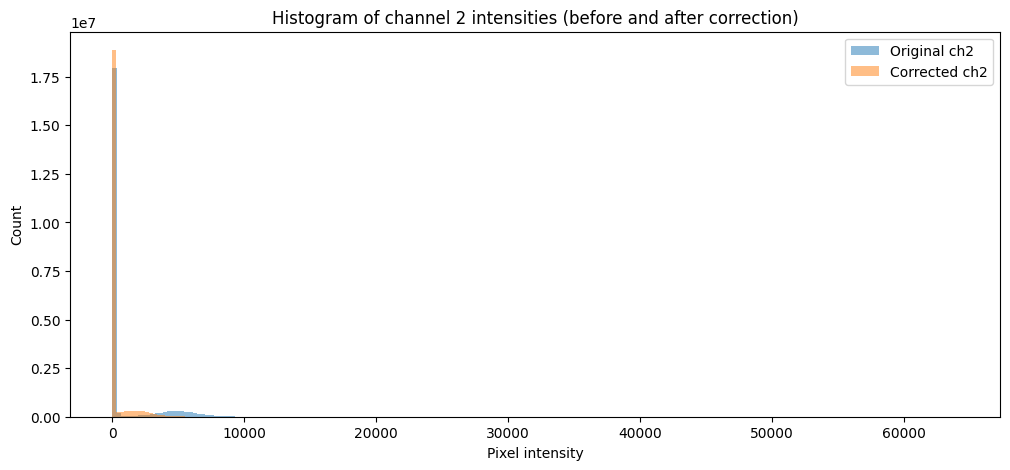

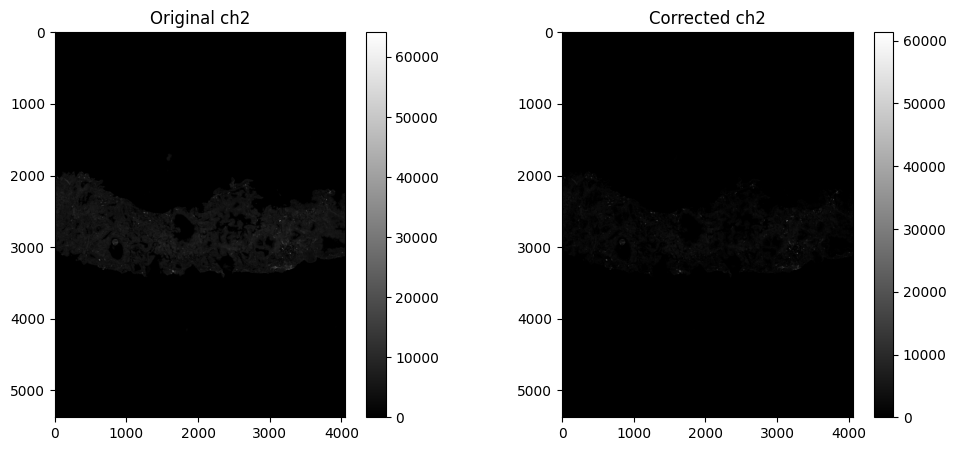

c:\Users\g\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


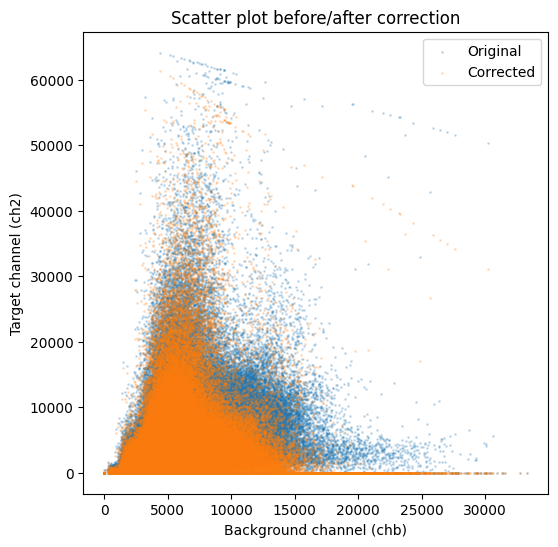

In [13]:
# Ensure float for plotting
ch2_float = ch2.astype(np.float64)
ch2_corrected_float = ch2_corrected_from7tiles.astype(np.float64)

# --- 1. Histograms ---
plt.figure(figsize=(12,5))
plt.hist(ch2_float.flatten(), bins=200, alpha=0.5, label='Original ch2')
plt.hist(ch2_corrected_float.flatten(), bins=200, alpha=0.5, label='Corrected ch2')
plt.xlabel('Pixel intensity')
plt.ylabel('Count')
plt.title('Histogram of channel 2 intensities (before and after correction)')
plt.legend()
plt.show()

# --- 2. Image comparison ---
# For visualisation, show a single slice if 3D or a full 2D image
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(ch2, cmap='gray')
plt.title('Original ch2')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(ch2_corrected, cmap='gray')
plt.title('Corrected ch2')
plt.colorbar()

plt.show()

# --- 3. Scatter plot of background vs target pixels (optional) ---
plt.figure(figsize=(6,6))
plt.scatter(chb.flatten(), ch2.flatten(), s=1, alpha=0.2, label='Original')
plt.scatter(chb.flatten(), ch2_corrected.flatten(), s=1, alpha=0.2, label='Corrected')
plt.xlabel('Background channel (chb)')
plt.ylabel('Target channel (ch2)')
plt.title('Scatter plot before/after correction')
plt.legend()
plt.show()

In [ ]:
TO-DO:
# Save only channel 2 with no background signal
# Enquire why the image is a bit pixellated when zooming on QuPath, same applies to the original image
# Query the compression options for OME-TIFF

#### Picking out a good threshold

In [ ]:
# Look at the global statistics of the target channel
print("Channel 2 - min:", ch2.min(), "max:", ch2.max(), "mean:", ch2.mean())

Channel 2 - min: 0.0 max: 64105.0 mean: 849.1705


In [7]:
# Sample 20 random tiles and print stats
tile_stats = []
for _ in range(20):
    y = np.random.randint(0, H - tile_size)
    x = np.random.randint(0, W - tile_size)
    tile = ch2[y:y+tile_size, x:x+tile_size]
    tile_stats.append((tile.mean(), tile.max()))

for i, (m, mx) in enumerate(tile_stats):
    print(f"Tile {i+1}: mean={m:.1f}, max={mx}")


Tile 1: mean=0.0, max=0.0
Tile 2: mean=4370.6, max=62686.0
Tile 3: mean=776.3, max=56971.0
Tile 4: mean=0.1, max=954.0
Tile 5: mean=2833.0, max=63826.0
Tile 6: mean=2339.8, max=57841.0
Tile 7: mean=10.1, max=2037.0
Tile 8: mean=0.0, max=0.0
Tile 9: mean=0.0, max=0.0
Tile 10: mean=0.0, max=0.0
Tile 11: mean=0.7, max=983.0
Tile 12: mean=2212.9, max=63667.0
Tile 13: mean=2500.8, max=63667.0
Tile 14: mean=284.3, max=53970.0
Tile 15: mean=3127.8, max=63826.0
Tile 16: mean=1119.9, max=43448.0
Tile 17: mean=21.0, max=10960.0
Tile 18: mean=390.6, max=53970.0
Tile 19: mean=0.0, max=0.0
Tile 20: mean=0.0, max=0.0


#### Using rembg for background removal

#### 1. Load the required packages and dependencies

In [11]:
%pip install rembg pillow tifffile matplotlib
%pip install onnxruntime

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rembg import remove
from pathlib import Path

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 2. Load the image and isolate channel 2

In [ ]:
# Load the full OME-TIFF
arr = tiff.imread("C:/Users/g/Downloads/7ch_corrected_channel2_from7tiles.ome.tif")
print("Image shape:", arr.shape)  # should be (7, H, W)

# Extract Channel 2 (assuming index 1) 
ch2 = arr[1]

# --- Optional: show basic stats ---
print(f"Channel 2 - min: {ch2.min()} max: {ch2.max()} mean: {ch2.mean()}")


Image shape: (7, 5376, 4056)
Channel 2 - min: 0 max: 61346 mean: 290.251984814898


#### 3. Normalise to 8-bit for rembg input

In [ ]:
# Normalise Channel 2 to 0–255 range for rembg
ch2_norm = (255 * (ch2 - ch2.min()) / (ch2.max() - ch2.min())).astype(np.uint8)

# Convert to PIL Image
img = Image.fromarray(ch2_norm)


#### 4. Apply background removal using rembg

100%|#######################################| 176M/176M [00:00<00:00, 14.6GB/s]


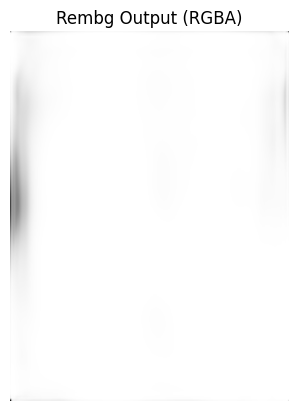

In [15]:
# Run rembg to remove background
img_no_bg = remove(img)

# Convert rembg output to RGBA (it contains transparency info)
img_no_bg = img_no_bg.convert("RGBA")

# Optional: visualise rembg output 
plt.imshow(img_no_bg)
plt.title("Rembg Output (RGBA)")
plt.axis('off')
plt.show()


#### 5. Convert RGBA to grayscale

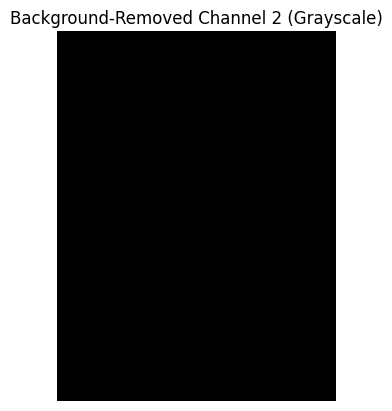

In [16]:
# Convert RGBA array to grayscale with transparency mask
data = np.array(img_no_bg)

# Extract alpha (transparency) channel: 255 = visible, 0 = background
alpha = data[..., 3]

# Apply mask to red channel (assuming grayscale stored in R)
gray_no_bg = (data[..., 0].astype(np.float32) * (alpha / 255.0)).astype(np.uint8)

# --- Optional: visualise masked grayscale image ---
plt.imshow(gray_no_bg, cmap='gray')
plt.title("Background-Removed Channel 2 (Grayscale)")
plt.axis('off')
plt.show()


#### 6. Save the image at TIFF for visualisation using QuPath

In [23]:
# Save the background-removed image
downloads_path = Path("C:/Users/g/Downloads")

output_path = downloads_path / "7ch_corrected_channel2_from7tiles_no_bg.ome.tif"

tiff.imwrite(output_path, gray_no_bg, photometric='minisblack')

print(f"✅ Saved background-removed Channel 2 to: {output_path}")


✅ Saved background-removed Channel 2 to: C:\Users\g\Downloads\7ch_corrected_channel2_from7tiles_no_bg.ome.tif


#### Trial and error

In [ ]:
print("no_bg min:", gray_no_bg.min(), "max:", gray_no_bg.max(), "mean:", gray_no_bg.mean())

# This code shows that rembg is not appropriate for this type of image, as it removes all of the signal.
# It cannot differentiate between background and true signal in fluorescence microscopy images.
# This machine-learning model is trained on natural images, not scientific microscopy data.

no_bg min: 0 max: 0 mean: 0.0
